### Cruise Ship Crew Size Prediction

Congratulations! You've been contracted by Hyundai Heavy Industries to help them build a predictive model for some ships. Hyundai Heavy Industries is one of the world's largest ship manufacturing companies and builds cruise liners.

You've been flown to their headquarters in Ulsan, South Korea to help them give accurate estimates of how many crew members a ship will require.

They are currently building new ships for some customers and want you to create a model and use it to predict how many crew members the ships will need.

Here is what the data looks like so far:

Description: Measurements of ship size, capacity, crew, and age for 158 cruise
ships.

Variables/Columns <br>
Ship Name     1-20 <br>
Cruise Line   21-40 <br>
Age (as of 2013)   46-48 <br>
Tonnage (1000s of tons)   50-56 <br>
passengers (100s)   58-64 <br>
Length (100s of feet)  66-72 <br>
Cabins  (100s)   74-80 <br>
Passenger Density   82-88 <br>
Crew  (100s)   90-96

In [12]:
from IPython.core.display import display, HTML
display(HTML("<style>.container{width:100% !imporant;}</style>"))

In [13]:
# import
from pyspark.sql import SparkSession
import seaborn as sns
%matplotlib inline

In [14]:
# Start Spark Session
spark = SparkSession.builder.appName('Linear_Regression').getOrCreate()

In [15]:
# Read Data
df = spark.read.csv('cruise_ship_info.csv', inferSchema=True, header=True)

In [16]:
# View Data
df.show()

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36|10.0|
|    Ecstasy|   Carnival| 22|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|
|    Elation|   Carnival| 15|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|
|    Fantasy|   Carnival| 23| 

In [17]:
df.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



### Split Data to avoid contamination

In [24]:
train_data, test_data = df.randomSplit([.8, .2])

In [25]:
train_data.count()

124

In [26]:
test_data.count()

34

### Quick Analysis

In [27]:
train_data.describe().show()

+-------+---------+-----------+------------------+-----------------+------------------+------------------+-----------------+-----------------+-----------------+
|summary|Ship_name|Cruise_line|               Age|          Tonnage|        passengers|            length|           cabins|passenger_density|             crew|
+-------+---------+-----------+------------------+-----------------+------------------+------------------+-----------------+-----------------+-----------------+
|  count|      124|        124|               124|              124|               124|               124|              124|              124|              124|
|   mean|     null|       null|15.524193548387096|71.11874193548388|18.367419354838713| 8.109758064516127| 8.79362903225807|40.00701612903227|7.762741935483876|
| stddev|     null|       null| 6.987170251599432|37.98635184491538|   9.7484211663913|1.7348974167605418|4.562561563843903|9.193210023507737|3.528110883235669|
|    min|Adventure|    Azamara|   

### There are too many categories in Ship_name and Cruise_line to be used as a variable

In [28]:
train_data.select("Ship_name").distinct().count()

110

In [30]:
train_data.select("Cruise_line").distinct().count()

19

In [31]:
train_data.groupby("Cruise_line").mean().show()

+-----------------+------------------+------------------+------------------+------------------+------------------+----------------------+------------------+
|      Cruise_line|          avg(Age)|      avg(Tonnage)|   avg(passengers)|       avg(length)|       avg(cabins)|avg(passenger_density)|         avg(crew)|
+-----------------+------------------+------------------+------------------+------------------+------------------+----------------------+------------------+
|            Costa|            16.875|         67.730875|17.560000000000002| 8.063749999999999|           8.80125|               37.8125|            7.5175|
|              P&O|              14.2| 78.23060000000001|            21.236|             8.596| 9.870000000000001|                  37.7|             8.606|
|           Cunard|               8.0|             120.7|              23.1|             10.48|            10.815|    51.394999999999996|            10.765|
|Regent_Seven_Seas|              15.8|             32.14| 

In [32]:
train_data.groupby("Cruise_line").count().show()

+-----------------+-----+
|      Cruise_line|count|
+-----------------+-----+
|            Costa|    8|
|              P&O|    5|
|           Cunard|    2|
|Regent_Seven_Seas|    5|
|              MSC|    7|
|         Carnival|   19|
|          Crystal|    2|
|         Princess|   10|
|        Silversea|    3|
|         Seabourn|    3|
| Holland_American|   12|
|         Windstar|    2|
|           Disney|    2|
|        Norwegian|    9|
|          Oceania|    3|
|          Azamara|    2|
|        Celebrity|    7|
|             Star|    4|
|  Royal_Caribbean|   19|
+-----------------+-----+



### Variable Selection Using Correlation

In [33]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd
import matplotlib.pyplot as plt

In [37]:
def print_corr_mat(numeric_cols):
    assembler = VectorAssembler(inputCols=numeric_cols, outputCol='corr_labels')
    corr_data = assembler.transform(train_data)
    corr_mat = Correlation.corr(corr_data, 'corr_labels').head()
    corr_pddf = pd.DataFrame(data=corr_mat[0].toArray(), index=numeric_cols, columns=numeric_cols)
    
    sns.heatmap(corr_pddf, annot=True)

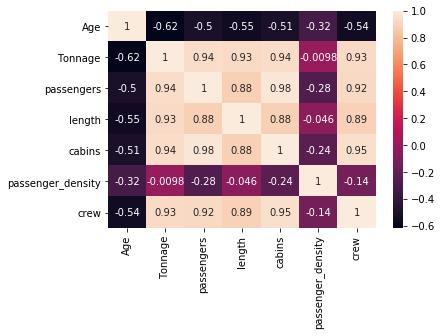

In [38]:
print_corr_mat(['Age', 'Tonnage', 'passengers', 'length', 'cabins', 'passenger_density', 'crew'])

#### Age and Cabins are the only viable features due to their correlation with Crew and lack of correlation with other variables

In [39]:
no_corr_cols = ['Age', 'cabins']

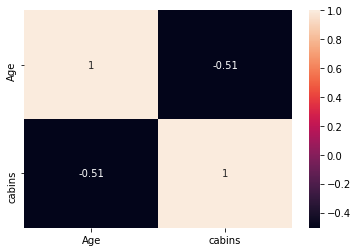

In [40]:
print_corr_mat(no_corr_cols)

In [50]:
from pyspark.ml.regression import LinearRegression

def lr_model(no_corr_cols, train_data, test_data):
    assembler = VectorAssembler(inputCols=no_corr_cols, outputCol='features')
    
    output_train = assembler.transform(train_data)
    output_test = assembler.transform(test_data)
    
    final_train_data = output_train.select('features', 'crew')
    final_test_data = output_test.select('features', 'crew')
 
    lr = LinearRegression(labelCol = 'crew')
    lr_model = lr.fit(final_train_data)
    lr_summary = lr_model.summary
    
    print('Model Intercept: ', lr_model.intercept)
    print('Coefficients:')
    
    for i,j in zip(no_corr_cols, lr_model.coefficients):
        print(i, ':', j)
    print()
    
    print('P-values:')
    for i,j in zip(no_corr_cols, lr_summary.pValues):
        print(i, ':', j)
    print()
    
    print('Model Performance Training Set:')
    train_result = lr_model.evaluate(final_train_data)
    print('R-squared:', str(train_result.r2))
    print('MAE:', str(train_result.meanAbsoluteError))
    
    return final_train_data, final_test_data, lr_model

### Training Set Performance

In [51]:
final_train_data, final_test_data, lr_model = lr_model(no_corr_cols, train_data, test_data)

Model Intercept:  2.1772296914290648
Coefficients:
Age : -0.040208147379482015
cabins : 0.7061602534535627

P-values:
Age : 0.011246315346750135
cabins : 0.0

Model Performance Training Set:
R-squared: 0.9138535369773763
MAE: 0.6843883043226564


### Test Set Performance

In [52]:
test_result = lr_model.evaluate(final_test_data)

In [53]:
test_result.r2

0.877242420836513

In [55]:
test_result.meanAbsoluteError

0.8718760806379829